In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import networkx as nx

In [3]:
import pandas as pd

In [4]:
from mentor_matching import reduce_full_tables

In [5]:
names_df = pd.read_csv('name_list.csv')
all_names = names_df.loc[:,::2].values.flatten()
for i in range(len(all_names)): 
    name = all_names[i]
    if type(name) == str:
        all_names[i] = name.replace(' ','')
names_df.head()

,Faculty,Faculty_initials,Postdocs,Postdocs_initials,GradStudents,Grad_initials,Undergrads,Undergrad_initials
0,Lilly Norton,AMG,Christiana Buckner,ABG,Subhaan Walsh,AMG,Maira Nava,NK
1,Anand Coulson,AMG,Yusuf Lucas,AMG,Amaan Terry,ABG,Marius Beil,AMG
2,Ruby-Leigh Holloway,AMG,Indigo Cope,AMG,Brennan Stanton,AMG,Khia Galindo,AMG
3,Kacie Chandler,AMG,Felicity Vo,ZD,Quinn Cobb,ABG,Willem Swan,TS
4,Iosif Chaney,TS,Alexander Mitchell,NK,Hannah Rivas,TS,Harris Bryan,ABG


In [6]:
mentees_df = pd.read_csv('mentees.csv')
#mentees_df.head()

In [7]:
mentors_df = pd.read_csv('mentors.csv')
#mentors_df.head()

In [8]:
people = reduce_full_tables(names_df,mentees_df,mentors_df)

In [9]:
for person in list(people.values())[::6][:10]:
    person.print_preferences()

Faculty: LillyNorton
nmentors: 0 [0. 0. 0. 0.]
nmentees: 3 [1. 1. 1. 0.] (2)
------
avoid  mentees: ['SubhaanWalsh', 'MairaNava']
avoid  mentors: []
------
prefer mentees: ['ChristianaBuckner']
prefer mentors: []
------

Faculty: AshleeWeir
nmentors: 0 [0. 0. 0. 0.]
nmentees: 0 [0. 0. 0. 0.] (1)
------
avoid  mentees: []
avoid  mentors: []
------
prefer mentees: []
prefer mentors: []
------

Postdocs: IndigoCope
nmentors: 1 [0. 0. 0. 1.]
nmentees: 0 [0. 0. 0. 0.] (0)
------
avoid  mentees: []
avoid  mentors: []
------
prefer mentees: []
prefer mentors: []
------

Postdocs: MehreenPearson
nmentors: 2 [0. 0. 1. 1.]
nmentees: 4 [1. 2. 1. 0.] (2)
------
avoid  mentees: ['IosifChaney']
avoid  mentors: ['IosifChaney', 'LukasLeech']
------
prefer mentees: []
prefer mentors: []
------

Postdocs: CohenO'Moore
nmentors: 4 [0. 0. 2. 2.]
nmentees: 4 [0. 4. 0. 0.] (3)
------
avoid  mentees: []
avoid  mentors: []
------
prefer mentees: []
prefer mentors: ['PiotrBernal']
------

GradStudents: HannahR

--------

In [37]:
from mentor_matching import generate_network
from network_metrics import run_all_metrics

In [38]:
nruns = 200
networks = ([])
vals = np.zeros((10,nruns))
for i in range(nruns):
    #print ('round', i)
    people, network = generate_network(names_df,mentees_df,mentors_df,loud=False)
    networks.append(network)
    vals[:,i],names = run_all_metrics(people, network)

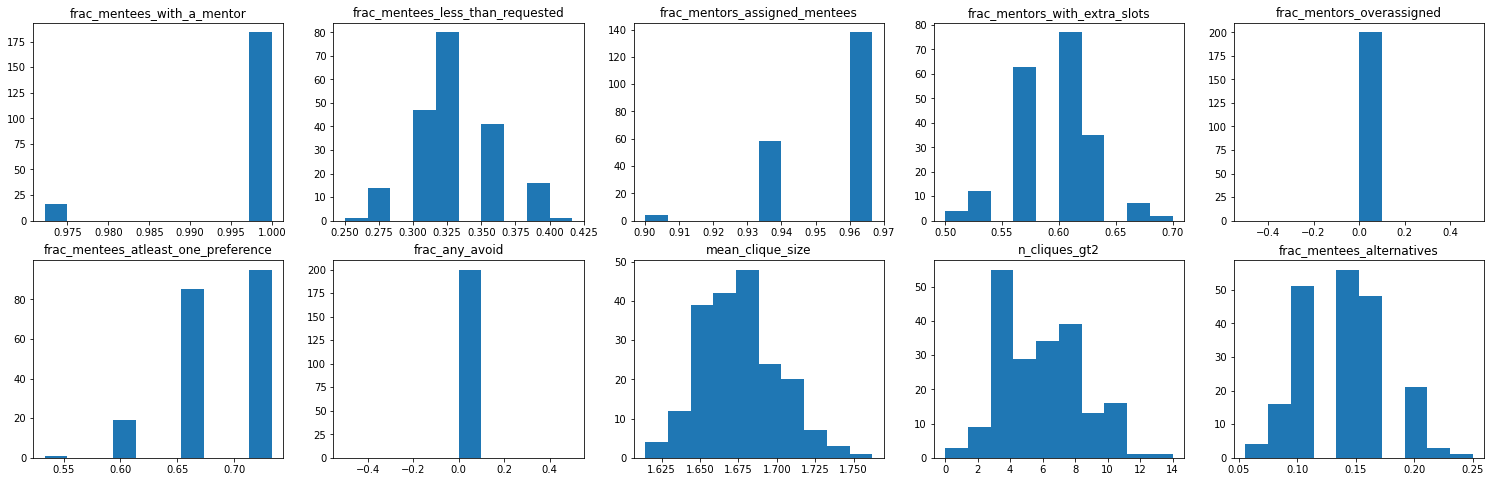

In [39]:
fig,axs = plt.subplots(nrows=2,ncols=5)
for i,ax in enumerate(axs.flatten()):
    if (i < len(vals)):
        ax.hist(vals[i], align = 'mid')
        ax.set_title(names[i])
fig.set_size_inches(26,8)

In [17]:
# testing a method to pick the best network
# in order of vals array
# 0: (top) maximize frac_mentees_with_a_mentor
# 1: maximize frac_mentees_less_than_requested
# 2: maximize frac_mentors_assigned_mentees ?
# 3: maximize frac_mentors_with_extra_slots ?
# 4: (top) throw out any with frac_mentors_overassigned --> required check
# 5: maximize frac_mentees_atleast_one_preference
# 6: (top) throw out any with frac_any_avoid > 0 --> required check
# 7: (top) maximize mean_clique_size
# 8: maximize n_cliques_gt
# 9: minmize alternative mentor assignments

combined_metric = [0]*nruns
topfac = 2.
midfac = 1.
#for normalizing the clique size
def norm_n_metric(val, arr):
    return (val - min(arr))/(max(arr) - min(arr))

for i in range(nruns):
    #top priority
    top = vals[0, i]*norm_n_metric(vals[7, i], vals[7])
    if (vals[4, i] > 0 or vals[6, i] > 0):
        top = 0
        
    #less important
    mid = vals[1,i]*vals[2,i]*vals[3,i]*vals[5,i]*norm_n_metric(vals[8,i], vals[8])
    
    #some
    combined_metric[i] = (topfac*top + midfac*mid)/(topfac + midfac)

#just a check
best = [i for (i, x) in enumerate(combined_metric) if x > 0.7]
print(best)
print(combined_metric[best[0]])
print('N with combined_metric > 0.7', len(best))

[124]
0.7113004115226338
N with combined_metric > 0.7 1


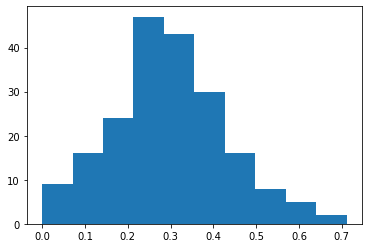

In [18]:
f, ax = plt.subplots()
_ = ax.hist(combined_metric)

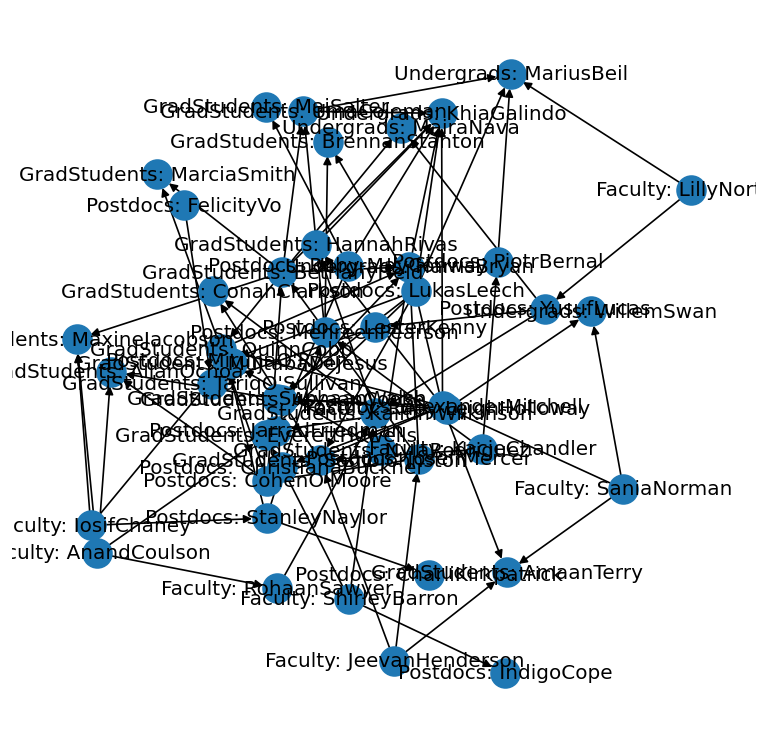

In [19]:
fig,ax = plt.subplots(1,1)
foo = nx.draw_kamada_kawai(networks[best[0]],ax=ax,with_labels=True)
fig.set_size_inches(8,8)
fig.set_dpi(120)